# Домашняя работа 1.3

### Ставится задача классификации текстов на написанных депрессивным или не депрессивным человеком.  

In [13]:
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, precision_score, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np
from scipy import stats

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)
%pylab inline

import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 6,3
pd.set_option('display.max_columns', 100)
train = pd.read_csv('train.csv', sep='\t')
test = pd.read_csv('test.csv', sep='\t')

test_with_result = pd.read_csv('test_with_result.csv', sep='\t')

test_with_result['label'] = test_with_result['label'].map({'Depression': 1, 'Non-depression': 0})

test_with_result_IDs = []
indexs_with_result = []
indexs_without_result = []
i = 0
for ID in test['ID']:
    if ID in list(test_with_result['ID']):
        test_with_result_IDs.append(ID)
        indexs_with_result.append(i)
    else: 
        indexs_without_result.append(i)
    i += 1

test = test.drop(test.index[indexs_without_result])

Populating the interactive namespace from numpy and matplotlib


In [14]:
train.head()

,ID,label,text
0,307,Non-depression,С детства я люблю футбол. Самые теплые воспоми...
1,243,Non-depression,Каждому человеку нужен мир. Мир- это весь земн...
2,73,Non-depression,"Я, другие и мир. Да, именно в таком порядке ме..."
3,301,Non-depression,Позиционирование себя как полноценного человек...
4,60,Non-depression,"Я, другие и мир. Такая неопределенная тема. Мы..."


### Предобработаем данные. 

In [15]:
train['is_test'] = 0
test['is_test'] = 1

In [16]:
data = pd.concat([train, test]).reset_index()

In [17]:
import pymorphy2
from nltk.tokenize import word_tokenize

class MorphProvider:
    def __init__(self):
        self.cache = {}
        self.morph = pymorphy2.MorphAnalyzer()
    
    def __call__(self, w):
        w = w.lower()
        cached = self.cache.get(w)
        if cached:
            return cached
        try:
            morphed = self.morph.parse(w)[0].normal_form
            self.cache[w] = morphed
            return morphed
        except:
            return None
    
    def morph_string(self, s):
        words = word_tokenize(s)
        return " ".join([self.__call__(w) for w in words])

morpher = MorphProvider()

from tqdm import tqdm

data["normalized"] = [morpher.morph_string(t) for t in tqdm(data.text)]

100%|████████████████████████████████████████████████████████████████████████████████| 316/316 [00:03<00:00, 86.01it/s]


In [18]:
data["normalized_words"] = data.normalized.apply(lambda x: ' '.join([w if w.isalpha() else 'num' for w in x.split() if w.isalpha() or w.isdigit()]))

In [19]:
morph = pymorphy2.MorphAnalyzer()

In [20]:
from nltk.corpus import stopwords

In [21]:
bad_words = ['социофобия', 'депрессия', 'боль', 'страх', 'ненависть',
             'ужас', 'боюсь', 'ужасный',
             'ненавидимый', 'презираемый', 'противный', 'болезнь',
             'обессилен', 'депрессивный', 'грустно', 'боялся', 'бояться',
             'тревога', 'болеть', 'плохо', 'смерть', 'тоска', 'неприятно','диагноз',
             'больным','Дискомфорт', 'грустный', 'необщительный', 'социопат', 'проблема', 
              'обман', 'прогнил', 'вина', 'умерло', 'ад', 'ненавижу', 'безразлична', 'жалости', 'расплакалась',
             'плакать', 'виноватой', 'закрытый',  'тяжело', 'сложно', 'непросто', 'низкая',
             'другие', 'портится', 'беспокоит', 'жесток', 'ленив', 'необщителен', 'безынициативен',
             'наказание', 'проблемы', 'замкнутость','страдаю', 'один', 'одинок', 'одиночество', 'заболевания' ]

In [22]:
i = 0
dict_bad_words = {}
for word in bad_words:
    i = 0
    while i < len(data):
        if morph.parse(word)[0].normal_form in\
        data.normalized_words[i].replace('!', '')\
                                .replace('?', '').replace('.', '').replace(',', '')\
                                .replace('–','').replace('.','').split():
            try:
                dict_bad_words[i] += 1
                #print(data.iloc[i][1])
            except:
                dict_bad_words[i] = 1
                #print(data.iloc[i][1])
        i += 1

In [23]:
good_words = ['радость', 'круто', 'счастье', 'улыбка', 'жизнь',
             'нравится', 'приятно', 'красивый',
             'любить', 'милый', 'здоровье', 'депрессивный', 'радостно', 'гордость', 'воля',
             'свобода', 'хорошо', "суицидальных", '']

In [24]:
i = 0
dict_good_words = {}
for word in good_words:
    i = 0
    while i < len(data):
        if morph.parse(word)[0].normal_form in\
        data.normalized_words[i].replace('!', '')\
                                .replace('?', '').replace('.', '').replace(',', '')\
                                .replace('–','').replace('.','').split():
            try:
                dict_good_words[i] += 1
                #print(data.iloc[i][1])
            except:
                dict_good_words[i] = 1
                #print(data.iloc[i][1])
        i += 1

In [25]:
bad_words_column = np.zeros(len(data))
for key, value in dict_bad_words.items():
    bad_words_column[key] = value

good_words_column = np.zeros(len(data))
for key, value in dict_good_words.items():
    good_words_column[key] = value
    
lens = []
for i in range(0, len(data)):
    lens.append(len(data.iloc[i, :].text))

In [26]:
data['lens'] = lens

In [27]:
import re
split_regex = re.compile(r'[.|!|?|…]')

number_sentensens = []
sentensens_mean_len = []
words_number = []
words_mean_len = []
punctuation_mark = []

for i in range(0, len(data)):
    punctuation_mark.append(len(data.text[i]) - len(''.join(data.text[i].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split())))
    number_sentensens.append(len(list(filter(lambda t: t, [t.strip() for t in split_regex.split(data.text[i])]))))
    sentensens_mean_len.append(len(''.join(split_regex.split(data.text[i])))/len(list(filter(lambda t: t, [t.strip() for t in split_regex.split(data.text[i])]))))
    words_number.append(len(data.text[i].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))
    words_mean_len.append(len(''.join(data.text[i].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))/len(data.text[i].replace('!', '').replace('?', '').replace('.', '').replace(',', '').replace('–','').replace('.','').split()))  

### Используем bag-of-words в качестве признаков.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['normalized_words']).toarray()
y = (train['label'] == 'Depression').astype(int)

In [29]:
from sklearn.feature_extraction.text import TfidfTransformer

X_all = TfidfTransformer(use_idf=False).fit_transform(X)
X_all.shape

(316, 7646)

In [30]:
feature_names = vectorizer.get_feature_names()

In [31]:
X_all = pd.DataFrame(X_all.toarray())

In [32]:
X_all.shape

(316, 7646)

### Добавим новые фичи.

In [33]:
X_all['bad_words'] = bad_words_column
X_all['good_words'] = good_words_column

X_all['lens'] = lens
X_all['lens_n'] = data[['lens']]/data[['lens']].sum()[0]
X_all['dif_med'] = abs(data['lens'] - data['lens'].median())
X_all['dif_mean'] = abs(data['lens'] - data['lens'].mean())
X_all['number_sentensens'] = number_sentensens
X_all['sentensens_mean_len'] = sentensens_mean_len
X_all['words_mean_len'] = words_mean_len
X_all['words_number'] = words_number
X_all['dif_std_med'] = X_all['dif_med'] - data['lens'].std()
X_all['dif_std_mean'] = X_all['dif_mean'] - data['lens'].std()
X_all['dif_mode'] = abs(data['lens'] - stats.mode(np.array(data['lens']))[0][0])
X_all['punctuation_mark'] = punctuation_mark
X_all['is_test'] = data['is_test']
X_all['dif_max'] = abs(data['lens'] - data['lens'].max())
X_all['dif_min'] = abs(data['lens'] - data['lens'].min())


X_all.loc[ X_all['lens'] <= 1000, 'lens_class'] = 0
X_all.loc[(X_all['lens'] > 1000) & (X_all['lens'] <= 1600), 'lens_class'] = 1
X_all.loc[(X_all['lens'] > 1600) & (X_all['lens'] <= 2300), 'lens_class'] = 2
X_all.loc[(X_all['lens'] > 2300) & (X_all['lens'] <= 4000), 'lens_class'] = 3
X_all.loc[ X_all['lens'] > 4000, 'lens_class'] = 4

X_all = pd.get_dummies(X_all, columns=['lens_class', 'bad_words', 'good_words'])
X_all['bad_words'] = bad_words_column
X_all['good_words'] = good_words_column

In [35]:
stopw = set(
    [w for w in stopwords.words(['russian', 'english'])]
    + [u'это', u'году', u'года', u'также', u'етот',
       u'которые', u'который', u'которая', u'поэтому',
       u'весь', u'свой', u'мочь', u'eтот', u'например',
       u'какой-то', u'кто-то', u'самый', u'очень', u'несколько',
       u'источник', u'стать', u'время', u'пока', u'однако',
       u'около', u'немного', u'кроме', u'гораздо', u'каждый',
       u'первый', u'вполне', u'из-за', u'из-под',
       u'второй', u'нужно', u'нужный', u'просто', u'большой',
       u'хотеть', u'начать', u'должный', u'новый', u'день',
       u'метр', u'получить', u'далее', u'именно', u'апрель',
       u'сообщать', u'разный', u'говорить', u'делать',
       u'появиться', u'2016',
       u'2015', u'получить', u'иметь', u'составить', u'дать', u'читать',
       u'ничто', u'достаточно', u'использовать',
       u'принять', u'практически',
       u'находиться', u'месяц', u'достаточно', u'что-то', u'часто',
       u'хотеть', u'начаться', u'делать', u'событие', u'составлять',
       u'остаться', u'заявить', u'сделать', u'дело',
       u'примерно', u'попасть', u'хотя', u'лишь', u'первое',
       u'больший', u'решить', u'число', u'идти', u'давать', u'вопрос',
       u'сегодня', u'часть', u'высокий', u'главный', u'случай', u'место',
       u'конец', u'работать', u'работа', u'слово', u'важный', u'сказать',
       u'то', u'по', u'на', u'как', u'что', u'это', u'или', u'не', u'нет', u'за']#, u'человек',u'мир', u'жизнь',
#      u'друг', u'который', u'хороший',u'жить', u'год', u'еще', u'num', u'к', u'отношение', u'ещё', u'наш',
#      u'понимать', u'думать', u'считать', u'стараться', u'знать', u'любить', u'общение', u'общаться', u'хотеться',
#      u'понять', u'вокруг', u'видеть', u'являться', u'являться', u'окружающий', u'чувствовать', u'кажется', u'близкие']
)



text_dict = {}
i = 0
for comment in data['normalized_words']:
    text_list = list(set(comment.split()))
    text_list_cleaned = []
    for word in text_list:
        if word not in list(stopw):
            text_list_cleaned.append(word)     
    text_dict[i] = text_list_cleaned
    i += 1

In [36]:
N_topics = 2

In [37]:
from gensim.corpora import TextCorpus
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

class ListTextCorpus(TextCorpus):

    def get_texts(self):
        for doc in self.input:
            yield doc
                
mycorp = ListTextCorpus(input=text_dict.values())
justlda = LdaModel(
    corpus=mycorp, num_topics=N_topics, passes=90)

In [38]:
print('LdaModel performance')
topic_description = {}
for i in range(N_topics):
    terms = justlda.get_topic_terms(i)
    topic_description[i] = ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms))
    print(i, ' '.join(map(lambda x: mycorp.dictionary.get(x[0]), terms)))

LdaModel performance
0 человек жизнь друг отношение хороший год любить общаться жить мир
1 человек мир жизнь друг хороший жить думать наш отношение считать


In [40]:
dummy_dict = {key: 0 for key in range(N_topics)}

comment_topics_dict_2 = {
    id: dict(list(dummy_dict.items()) + justlda.get_document_topics(mycorp.dictionary.doc2bow(normalized_words)))
    for id, normalized_words in text_dict.items()
}
check_pd_2 = pd.DataFrame.from_dict(comment_topics_dict_2, orient='index')
check_pd_2.head(15)

,0,1
0,0.000000,0.993245
1,0.000000,0.993464
2,0.260749,0.739251
3,0.000000,0.992779
4,0.363153,0.636847
5,0.994015,0.000000
6,0.807737,0.192263
7,0.978964,0.021036
8,0.118629,0.881371
9,0.991387,0.000000


In [41]:
check_pd_2.columns = ['class_1', 'class_2']
X_all['class_1'] = check_pd_2['class_1']
X_all['class_2'] = check_pd_2['class_2']
columns = X_all.columns

In [42]:
X_train = X_all[X_all.is_test==0]
X_test = X_all[X_all.is_test==1]

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns)

In [44]:
X_test_scaled = pd.DataFrame(scaler.transform((X_test)), columns=columns)

### Будем использовать xgboost в качестве нашего классификатора.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2)

In [46]:
#%%time
# parameters = {
#     'n_estimators':range(1,1000, 100),
#     'max_depth':range(1,9,1),
#     'min_samples_split':range(200,1001,400),
#     'learning_rate': np.linspace(0, 0.1, 12),
#     "max_features":np.linspace(0, 30, 7),
#     "subsample":np.linspace(0.5, 0.7, 12),
#  }


# gsearch = GridSearchCV(estimator=clf, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
# gsearch.fit(X_train_scaled,y)
# gsearch.best_params_

In [47]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost

In [48]:
clf = xgboost.XGBClassifier(
                    max_depth=5,
                    n_jobs=4,
                    n_estimators=101,
                    min_samples_split=200,
                    learning_rate=0.079,
                    max_features='log2',
                    subsample=0.6578947368421052
)

In [65]:
clf.fit(X=X_train, y=y_train)
y_train_predict = clf.predict_proba(X_train)[:, 1]
y_test_predict = clf.predict_proba(X_test)[:, 1]
y_TEST_predict = clf.predict_proba(X_test_scaled)[:, 1]
# y_train_predict = clf.predict(X_train)
# y_test_predict = clf.predict(X_test)

In [66]:
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 9)

print("Train: ", round(roc_auc_train, 9))
print("Test: ", round(roc_auc_test, 9))

Train:  1.0
Test:  0.900862069


**Теперь проверим на новых тестовых данных.**

In [71]:
y_TEST = test_with_result['label']

In [72]:
roc_auc_TEST = roc_auc_score(y_TEST, y_TEST_predict)
roc_auc_TEST

0.8794871794871795

In [73]:
y_predict = (y_TEST_predict > 0.1).astype(int)
roc_auc_score(y_TEST, y_predict)

0.8038461538461537

**Таким образом, мы получили достаточно хорошую точность предсказание депрессии по тексту.**

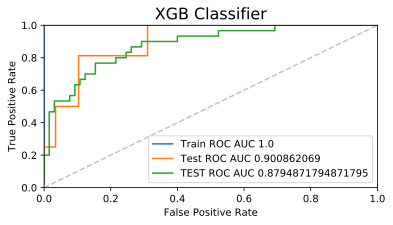

In [78]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)
fpr_TEST, tpr_TEST, thresholds_TEST = roc_curve(y_TEST, y_TEST_predict)


plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot(fpr_TEST, tpr_TEST, label='TEST ROC AUC {0}'.format(roc_auc_TEST))


plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [88]:
trues = list(y_TEST == y_predict)

i = 0
y_test_pr_True = [] 
y_test_pr_False = []
for value in trues:
    if value == True:
        y_test_pr_True.append(y_predict[i])
    elif value == False:
        y_test_pr_False.append(y_predict[i])
    i += 1

In [90]:
trace0 = go.Histogram(x=y_TEST, xbins=dict(start='Депрессия', end='Не депрессия', size=0.3), name='real' )
trace1 = go.Histogram(x=y_test_pr_True, xbins=dict(start='Депрессия', end='Не депрессия', size=0.3), name='predict True')
trace2 = go.Histogram(x=y_test_pr_False, xbins=dict(start='Депрессия', end='Не депрессия', size=0.3), name='predict False')

traces = [trace0, trace1, trace2]
layout = go.Layout(bargap=0.2,bargroupgap=0.1)
fig = go.Figure(data=traces, layout=layout)
iplot(fig, show_link=False)

In [91]:
precision_score(y_TEST, y_predict)

0.5869565217391305

In [92]:
recall_score(y_TEST, y_predict)

0.9

In [93]:
accuracy_score(y_TEST, y_predict)

0.7684210526315789

In [84]:
scores = cross_validate(
    clf, X_train_scaled, y, cv=4, scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall'), return_train_score=True
)
scores

{'fit_time': array([2.23203182, 2.22505116, 2.18814969, 2.4334929 ]),
 'score_time': array([0.2872324 , 0.27426696, 0.27526379, 0.27227283]),
 'test_accuracy': array([0.85714286, 0.85714286, 0.89090909, 0.83333333]),
 'test_f1': array([0.76470588, 0.76470588, 0.76923077, 0.57142857]),
 'test_precision': array([0.72222222, 0.72222222, 1.        , 1.        ]),
 'test_recall': array([0.8125, 0.8125, 0.625 , 0.4   ]),
 'test_roc_auc': array([0.9140625 , 0.859375  , 0.91185897, 0.92478632]),
 'train_accuracy': array([1., 1., 1., 1.]),
 'train_f1': array([1., 1., 1., 1.]),
 'train_precision': array([1., 1., 1., 1.]),
 'train_recall': array([1., 1., 1., 1.]),
 'train_roc_auc': array([1., 1., 1., 1.])}

In [85]:
rcParams['figure.figsize'] = (10, 15)
clf.feature_importances_

array([0.        , 0.        , 0.        , ..., 0.        , 0.01219512,
       0.        ], dtype=float32)


### Выведем самые важные фичи.

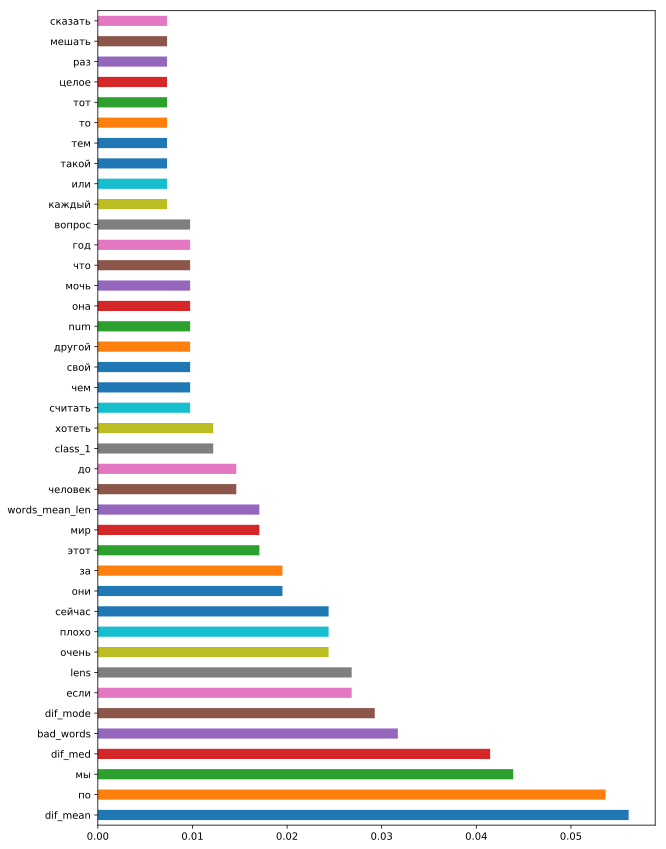

In [86]:
# xgboost.plot_importance(booster=clf)
IDcol = 'ID'
y_label = 'label'
predictors = [x for x in columns if x not in [y_label, IDcol]]

names = []
for i in predictors:
    try:
        names.append(feature_names[int(i)])
    except:
        names.append(i)

(pd.Series(clf.feature_importances_, names).sort_values(ascending=False))[:40].plot(kind='barh')
rcParams['figure.figsize'] = (6, 4)